In [1]:
""" setup """
import numpy as np

import matplotlib.pyplot as plt
plt.style.use(['classic'])

from redbaron import redbaron
redbaron.ipython_behavior = False

from pyha.simulation.simulation_interface import assert_sim_match

In [2]:
def dc_rem(inputs, alen):
    group_delay = int((alen-1)/2)
    
    taps = [1 / alen] * alen
    ret = np.convolve(inputs, taps, mode='full')[:-alen + 1]
    
    return inputs[:-group_delay] - ret[group_delay:]

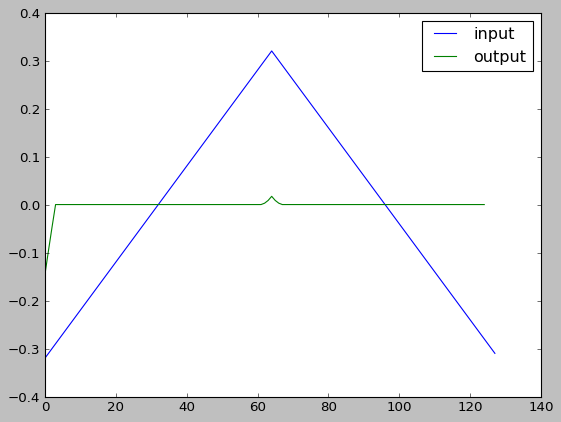

In [3]:
from pyha.simulation.simulation_interface import plot_assert_sim_match

l = list(range(-32, 32)) + list(range(32, -32, -1))
input = np.array(l) / 100

ref = dc_rem(input, 7)

plt.plot(input, label='input')
plt.plot(ref, label='output')
plt.legend()
plt.show()

# Freqz single MA

2048
2048


/home/gaspar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


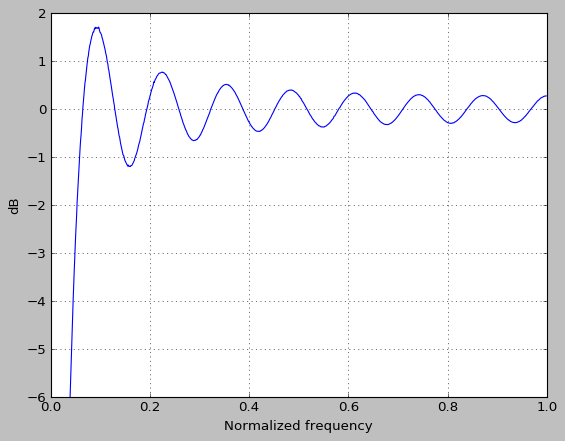

In [4]:
# https://se.mathworks.com/matlabcentral/newsreader/view_thread/154499
from scipy.fftpack import fft, fftshift


def estimate_frequency_phase_response(input, output):
    sum_h = None
    H1 = np.array([0 + 0 * 1j] * len(input[0]))
    for i, o in zip(input, output):
        I = fft(i)
        O = fft(o)
        new_h = I * O / I ** 2
        new_h /= len(input)  # average
        H1 += new_h

#     H1 = fftshift(H1)
    magnitude = 20 * np.log10(abs(H1))
    phase = np.angle(H1) * 180 / np.pi
    
    out_len = len(magnitude) // 2
    
    return magnitude[:out_len], phase[:out_len]

l = 2**11
u = [np.random.uniform(-1, 1, l) for _ in range(l)]
y = [dc_rem(x, 31)[:l] for x in u]

print(len(y))
print(len(y))

u = [x[:len(y[0])] for x in u]
mag8, _ = estimate_frequency_phase_response(u, y)


f = np.array(range(len(mag8))) / len(mag8)

plt.plot(f, mag8)

plt.xlabel("Normalized frequency")
plt.ylabel("dB")
plt.grid()
plt.legend()
plt.ylim(-6, 2)

plt.savefig('dc_single_freqz.png', bbox_inches='tight')

plt.show()

# Freqz quad MA

In [ ]:
def dc_rem_quad(inputs, alen):
    group_delay = int((alen-1)/2*4)
    
    taps = [1 / alen] * alen
    
    ret = inputs
    ret = np.convolve(ret, taps, mode='full')[:-alen + 1]
    ret = np.convolve(ret, taps, mode='full')[:-alen + 1]
    ret = np.convolve(ret, taps, mode='full')[:-alen + 1]
    ret = np.convolve(ret, taps, mode='full')[:-alen + 1]
    
    
    return inputs[:-group_delay] - ret[group_delay:]

In [ ]:
# https://se.mathworks.com/matlabcentral/newsreader/view_thread/154499
from scipy.fftpack import fft, fftshift


def estimate_frequency_phase_response(input, output):
    sum_h = None
    H1 = np.array([0 + 0 * 1j] * len(input[0]))
    for i, o in zip(input, output):
        I = fft(i)
        O = fft(o)
        new_h = I * O / I ** 2
        new_h /= len(input)  # average
        H1 += new_h

#     H1 = fftshift(H1)
    magnitude = 20 * np.log10(abs(H1))
    phase = np.angle(H1) * 180 / np.pi
    
    out_len = len(magnitude) // 2
    
    return magnitude[:out_len], phase[:out_len]

l = 2**12
u = [np.random.uniform(-1, 1, l) for _ in range(l)]
y = [dc_rem_quad(x, 32)[:l] for x in u]

print(len(y))
print(len(y))

u = [x[:len(y[0])] for x in u]
mag8, _ = estimate_frequency_phase_response(u, y)


f = np.array(range(len(mag8))) / len(mag8)

plt.plot(f, mag8)

plt.xlabel("Normalized frequency")
plt.ylabel("dB")
plt.grid()
plt.legend()
plt.ylim(-1, 1)

plt.savefig('dc_quad_freqz.png', bbox_inches='tight')

plt.show()

4096
4096


In [ ]:
""" harmonic """
input = np.sin(2 * np.pi * np.linspace(0, 40, 1024)) * 0.5
input[300:500] = input[300:500] + 0.25
input[600:900] = input[600:900] - 0.25
model = DCRemoval(128)
ref = model.model_main(input)

plt.plot(input, label='input')
plt.plot(ref, label='output')
plt.legend()
plt.show()

assert_sim_match(model, ref, input)